In [1]:
import pandas as pd
import numpy as np


seed = 44
np.random.seed(seed)

print("Reading file...")
all_df = pd.read_csv('data.csv', low_memory=False)
print("Done reading!")

Reading file...
Done reading!


In [2]:
# Sanity Check
print(all_df.keys())

Index(['steamId', 'itadPlain', 'itad.position', 'itad.rank', 'steam.name',
       'steam.steam_appid', 'steam.required_age', 'steam.is_free', 'steam.dlc',
       'steam.reviews',
       ...
       'steam.short_description.compound', 'steam.ext_user_account_notice',
       'timestamp', 'year', 'month', 'day', 'daysSinceLaunch', 'price',
       'percentOfMaxPrice', 'isSteamSale'],
      dtype='object', length=131)


In [3]:
pd.to_datetime(all_df['timestamp'] * 1000000000)

0         2017-03-03 00:30:00
1         2017-03-04 00:30:00
2         2017-03-05 00:30:00
3         2017-03-06 00:30:00
4         2017-03-07 00:30:00
                  ...        
4407820   2022-03-03 00:30:00
4407821   2022-03-04 00:30:00
4407822   2022-03-05 00:30:00
4407823   2022-03-06 00:30:00
4407824   2022-03-07 00:30:00
Name: timestamp, Length: 4407825, dtype: datetime64[ns]

In [4]:
all_df.dtypes

steamId                int64
itadPlain             object
itad.position          int64
itad.rank              int64
steam.name            object
                      ...   
day                    int64
daysSinceLaunch        int64
price                float64
percentOfMaxPrice    float64
isSteamSale             bool
Length: 131, dtype: object

In [5]:
all_df['time'] = pd.to_datetime(all_df['timestamp'] * 1000000000)

In [6]:
all_df['time']

0         2017-03-03 00:30:00
1         2017-03-04 00:30:00
2         2017-03-05 00:30:00
3         2017-03-06 00:30:00
4         2017-03-07 00:30:00
                  ...        
4407820   2022-03-03 00:30:00
4407821   2022-03-04 00:30:00
4407822   2022-03-05 00:30:00
4407823   2022-03-06 00:30:00
4407824   2022-03-07 00:30:00
Name: time, Length: 4407825, dtype: datetime64[ns]

In [7]:
all_df = all_df.rename({'time': 'ds', 'percentOfMaxPrice': 'y'}, axis='columns')

We want to predict `percentOfReleasePrice` instead of just `price` because of the following:
  - games can start at many prices
  - the starting price of a game is variable (changes over time)
    - e.g. a AAA game in 2015 released at $60, now the base release price is $80
    - It usually jumps in 5-10 dollar increments to keep the consumer happy.
    - @christian can you please find a citation for this or similar metric? Basically want to say that there is a trend in price (but trend is discrete as well)
  - Game launch price is immediately available, if the game is available
    - It's also very easy to translate an absolute price (e.g. $20) into a % of the release price, so it stays user-friendly as well.
  - If we normalize, we'll be able to generalize more (it's more effective when predicting between 0 and 1, rather than having a varying range)
    - We should be normalizing data anyway for ML lol

In [8]:
all_df['y']

0          1.000000
1          0.880812
2          0.880812
3          0.880812
4          0.880812
             ...   
4407820    0.248186
4407821    0.248186
4407822    0.248186
4407823    0.248186
4407824    0.224005
Name: y, Length: 4407825, dtype: float64

<AxesSubplot:ylabel='Frequency'>

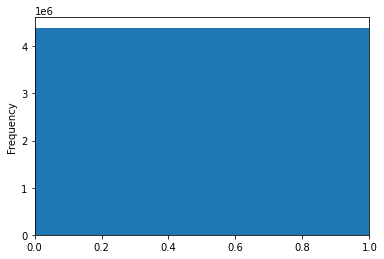

In [9]:
# Look at the average proportions of how the prices are distributed
all_df['y'].sort_index().plot.hist(bins=20, xlim=(0,1), x="Cost ($)", y="Frequency (Days)")

We can see that most games for most of the time like to stay at their original release price.
There are no games that have increased in price.
Games do not like 20%, 30% discounts, but rather like having stuff at 20-50% of its original price.
Discount percentage prefers to be in a nice, human-readable number (0.25, 0.4, 0.5)
  - 0.53, 0.54 disprove this rule

In [10]:
# Split each game into its own dataframe for easier forecasting
dfs = [v for k, v in all_df.groupby('itadPlain')]
len(dfs)

2227

In [11]:
# One dataframe per game, in a list.
dfs[0].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,price,y,isSteamSale,ds
2749246,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.455928e+09,2016,2,20,0,13.7522,1.000000,False,2016-02-20 00:30:00
2749247,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456015e+09,2016,2,21,1,10.9900,0.799145,False,2016-02-21 00:30:00
2749248,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456101e+09,2016,2,22,2,10.9900,0.799145,False,2016-02-22 00:30:00
2749249,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456187e+09,2016,2,23,3,10.9900,0.799145,False,2016-02-23 00:30:00
2749250,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456274e+09,2016,2,24,4,10.9900,0.799145,False,2016-02-24 00:30:00


In [12]:
dfs[1].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,price,y,isSteamSale,ds
4262827,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.491957e+09,2017,4,12,0,13.59,0.799882,False,2017-04-12 00:30:00
4262828,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492043e+09,2017,4,13,1,13.59,0.799882,False,2017-04-13 00:30:00
4262829,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492130e+09,2017,4,14,2,13.59,0.799882,False,2017-04-14 00:30:00
4262830,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492216e+09,2017,4,15,3,13.59,0.799882,False,2017-04-15 00:30:00
4262831,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492303e+09,2017,4,16,4,13.59,0.799882,False,2017-04-16 00:30:00


In [13]:
# Let's try to naively throw our data into FB Prophet, and see what it spits out.
from prophet import Prophet

m = Prophet()
m.fit(dfs[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -68.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3021.41   2.84755e-05       75.0057      0.4144      0.4144      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       3021.58    0.00152228       88.3342   1.516e-05       0.001      235  LS failed, Hessian reset 
     194       3021.66    1.9342e-05       68.9607   2.448e-07       0.001      329  LS failed, Hessian reset 
     199       3021.66    2.0101e-06       75.5806      0.1734           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       3021.67   3.17353e-07       87.6213       1.243      0.3532      412   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2568,2023-03-03 00:30:00,0.799217,0.591445,0.998641
2569,2023-03-04 00:30:00,0.798389,0.596479,1.016419
2570,2023-03-05 00:30:00,0.795439,0.588504,0.989548
2571,2023-03-06 00:30:00,0.791777,0.597361,0.979526
2572,2023-03-07 00:30:00,0.788063,0.590625,0.984191


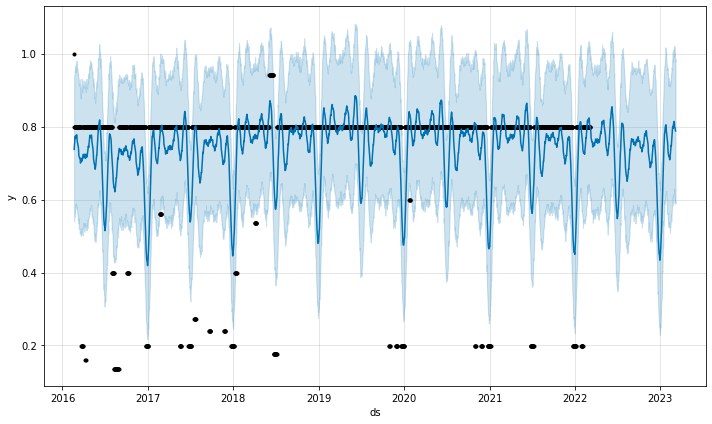

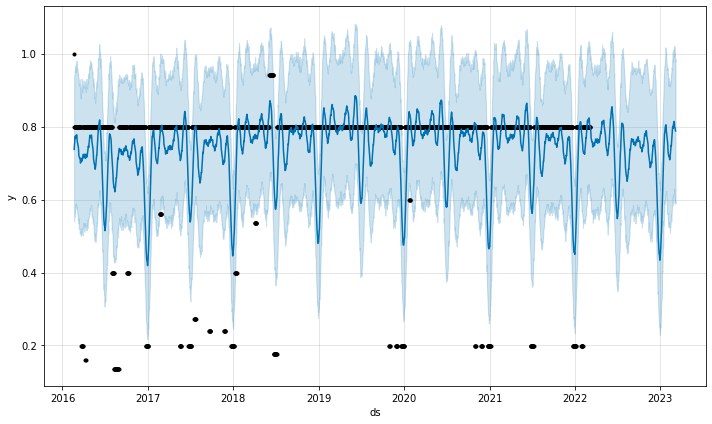

In [15]:
m.plot(forecast)

Hmm uhh..... This doesn't look good. Let's just look at the seasonal components for good measure.

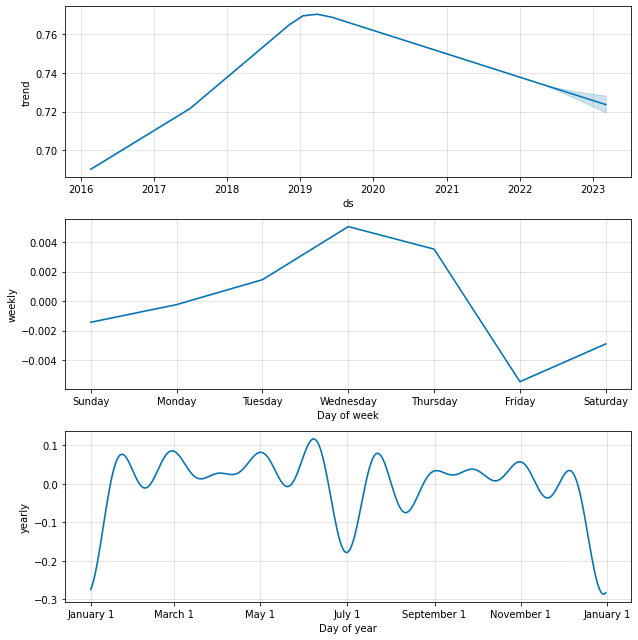

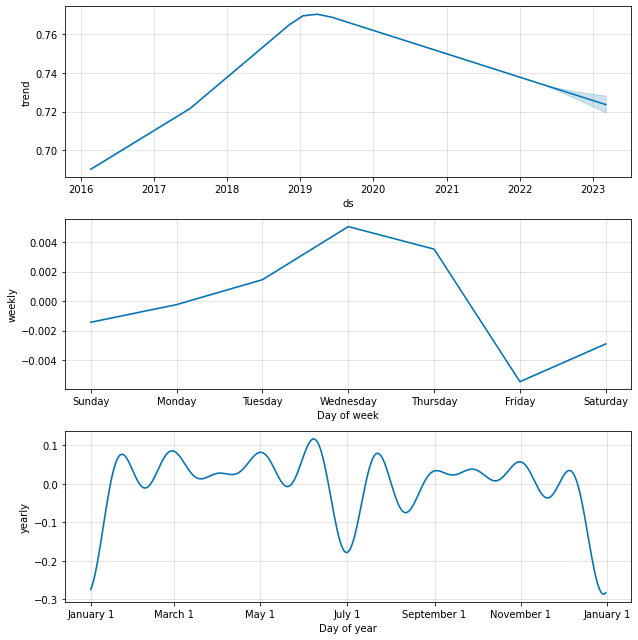

In [16]:
m.plot_components(forecast)

Looks kinda suspicious, and the values don't actually converge to where it's at, but this really does end up predicting the main sale points using yearly seasonality.
It also predicts how there's frequent weekend sales (Fri, Sat, Sun games cheaper than midweek).



In [17]:
# Let's just try it again with another game to make sure.
m = Prophet()
m.fit(dfs[1732])
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -153.267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3371.86    0.00300456        93.905      0.8206      0.8206      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3373.31    0.00131939       83.4257   1.833e-05       0.001      255  LS failed, Hessian reset 
     199        3373.5   2.70791e-05       75.5158           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       3373.87   0.000366695       82.5709   5.196e-06       0.001      449  LS failed, Hessian reset 
     299        3373.9   2.79115e-06        69.351      0.4918      0.4918      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326        3373.9   6.69929e-08       56.7497       0.271           1      530   
Optimization terminat

,ds,yhat,yhat_lower,yhat_upper
2568,2023-03-03 00:30:00,0.540586,0.375226,0.704990
2569,2023-03-04 00:30:00,0.542950,0.379472,0.706065
2570,2023-03-05 00:30:00,0.541251,0.372757,0.698322
2571,2023-03-06 00:30:00,0.538579,0.370688,0.700610
2572,2023-03-07 00:30:00,0.538128,0.372080,0.712062


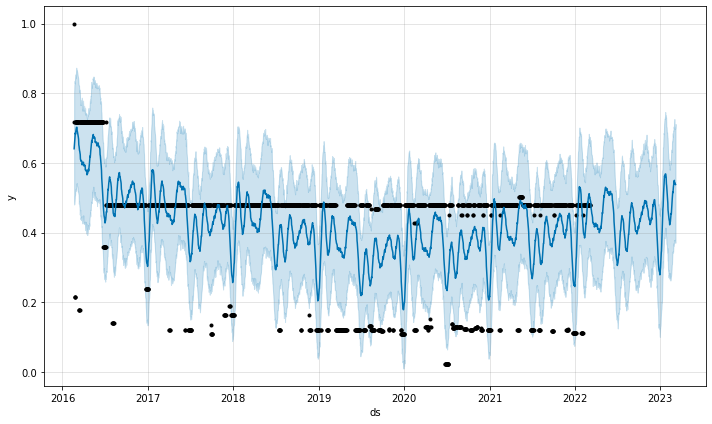

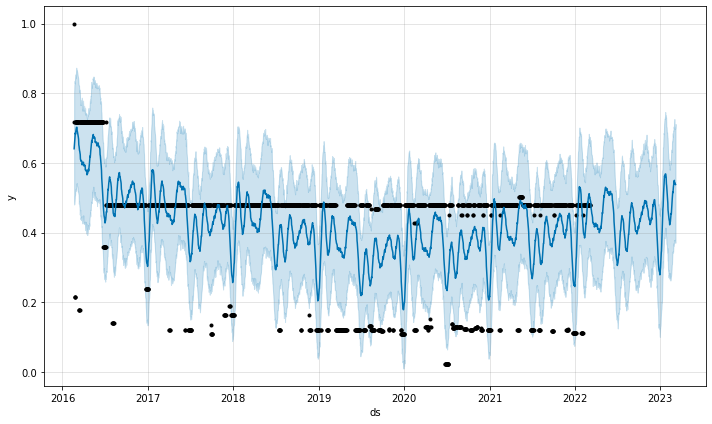

In [18]:
m.plot(forecast)

As we can see, this wasn't very good either. This is probably because sales are always discrete (jump from 100% to 40% price in a day, then jumping back up immediately.) For Prophet, as well as other ML models and the traditional methods (ARIMA, SARIMA, Holt-Winter) both expect a rather continuous distribution.

Let's take another look at our problem again.

We want to be able to predict the prices of games, yes, but why do we want that? We want to predict the prices so that users can decide whether they want to wait or not in order to get a game at a certain price.

That means that the actual proportion of time in a given sliding window (or a given time period) does not matter. Only if it reached it.

This reasoning gives us 3 options (all done using sliding windows of 7, 30, 90, 180 days):
 - Bucket the `percentOfOriginalPrice` into intervals of 0.8 or 0.1, and predict whether a given interval will show up
    - This is just logistic regression a bunch of times isn't it.
    - I predict that this one will work the best, and will be the most usable.
 - If we actually care about proportion of time it will show up, we can make it show the % of the sliding window being in a given bucket.
    - This will make the data more continuous (as data enters the sliding window it will slowly change the % values), but at the same time, we don't really care about the % of time that a game is a given price. Just that it reaches a cheap enough price.
    - If we make it continuous, we should be able to use the original models we wanted to use (Prophet, SARIMA, etc)
 - Our "original" idea, which is to:
   - cluster games by trends (k-mean or som)
     - SOM = self-organizing map
        - https://github.com/JustGlowing/minisom
        - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=37
     - Dynamic time barycenter averaging
       - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=44
       - ts-learn
       - Extra important because new games will be coming in at different times, however will still most likely follow the same trends (e.g. get to half price by the end of 3 years)
         - alternatively, we could use "Days since launch" column instead of timestamp as a way to phase time since launch date.
     - k-means
       - use DTW (dynamic time warping)
   - from those group results, run a rule-finder or make a classifier so that we can find a trend, given a game's attributes (e.g. multiplayer, supports linux, has 2 developers)
   - Run the classifier, then use that trend model to predict.

In [19]:

def nparray_tail(x: np.array, n:int):
    """
    Returns tail N elements of array.
    :param x: Numpy array.
    :param n: N elements to return on end.
    :return: Last N elements of array.
    """
    if n == 0:
        return x[0:0]  # Corner case: x[-0:] will return the entire array but tail(0) should return an empty array.
    else:
        return x[-n:]  # Normal case: last N elements of array.

Now, let's try to establish our train/test split.

We'll do

In [20]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler



onlyTrend = []
for df in dfs:
    onlyTrend.append(df['y'])

trends = np.array(onlyTrend, dtype=object)
nparray_tail(trends, 2)


/usr/local/lib/python3.8/dist-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


array([2388447    1.000000
       2388448    0.799273
       2388449    0.799273
       2388450    0.799273
       2388451    0.799273
                    ...
       2390650    0.799273
       2390651    0.799273
       2390652    0.799273
       2390653    0.799273
       2390654    0.799273
       Name: y, Length: 2208, dtype: float64,
       2653532    0.849893
       2653533    0.849893
       2653534    0.849893
       2653535    0.849893
       2653536    0.849893
                    ...
       2655599    0.837741
       2655600    0.837741
       2655601    0.837741
       2655602    0.837741
       2655603    0.837741
       Name: y, Length: 2072, dtype: float64], dtype=object)

In [21]:
len(trends)

2227

In [22]:
len(trends[0])

2208

In [23]:
trends

array([2749246    1.000000
       2749247    0.799145
       2749248    0.799145
       2749249    0.799145
       2749250    0.799145
                    ...
       2751449    0.799145
       2751450    0.799145
       2751451    0.799145
       2751452    0.799145
       2751453    0.799145
       Name: y, Length: 2208, dtype: float64,
       4262827    0.799882
       4262828    0.799882
       4262829    0.799882
       4262830    0.799882
       4262831    0.799882
                    ...
       4264613    1.000000
       4264614    1.000000
       4264615    1.000000
       4264616    1.000000
       4264617    1.000000
       Name: y, Length: 1791, dtype: float64,
       2356105    1.000000
       2356106    1.000000
       2356107    1.000000
       2356108    1.000000
       2356109    1.000000
                    ...
       2358308    0.673953
       2358309    0.673953
       2358310    0.673953
       2358311    0.673953
       2358312    0.673953
       Name: y, Length: 22

In [24]:
# Convert it so that it's compatible with numpy
for i in range(0, len(trends)):
    trends[i] = trends[i].to_numpy()



In [25]:
trends

array([array([1.        , 0.79914486, 0.79914486, ..., 0.79914486, 0.79914486,
              0.79914486])                                                    ,
       array([0.79988228, 0.79988228, 0.79988228, ..., 1.        , 1.        ,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.67395264, 0.67395264,
              0.67395264])                                                    ,
       ...,
       array([0.84120621, 0.7774098 , 0.7774098 , ..., 0.73853931, 0.73853931,
              0.73853931])                                                    ,
       array([1.        , 0.79927273, 0.79927273, ..., 0.79927273, 0.79927273,
              0.79927273])                                                    ,
       array([0.84989278, 0.84989278, 0.84989278, ..., 0.83774124, 0.83774124,
              0.83774124])                                                    ],
      dtype=object)

In [26]:
# Standardize the length, then normalize around 0
X_train = TimeSeriesResampler(sz=80).fit_transform(trends)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
np.random.shuffle(X_train)
sz = X_train.shape[1]

In [27]:
X_train

array([[[ 1.93374815],
        [-1.93908935],
        [-2.64466216],
        ...,
        [ 0.40240367],
        [ 0.40240367],
        [ 0.40240367]],

       [[ 3.41454433],
        [ 0.53437306],
        [ 2.21389462],
        ...,
        [ 1.73918687],
        [-0.58868377],
        [-0.53441338]],

       [[ 1.88856566],
        [ 1.43727091],
        [ 1.15452113],
        ...,
        [ 1.11455712],
        [ 0.08794274],
        [ 1.11142101]],

       ...,

       [[ 1.33374238],
        [ 0.98242062],
        [ 0.88087275],
        ...,
        [ 0.98038966],
        [ 0.98038966],
        [ 0.94005823]],

       [[ 2.08620178],
        [-1.17998628],
        [ 0.89598071],
        ...,
        [ 0.89598071],
        [ 0.89598071],
        [ 0.89598071]],

       [[ 1.57287584],
        [ 0.57966895],
        [ 0.57966895],
        ...,
        [-1.32243003],
        [-1.32243003],
        [-1.32243003]]])

## Let's try out a bunch of clustering modules from tslearn


In [28]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import datetime


def benchmark_train_model(length=100,max_iter=10):
    start = datetime.datetime.now()
    print(f"[BENCH] starting model benchmark, length={length}, max_iter={max_iter}")
    model = TimeSeriesKMeans(n_clusters=16, metric="dtw", n_jobs=-1, max_iter=max_iter, random_state=seed)
    model.fit(X_train[0:length])
    end = datetime.datetime.now()
    print("[BENCH] done!", (end-start))
    return model

In [29]:
# Experiment 1
# Trying to find out how the TimeSeriesKMeans clustering scales
# Hypothesis: Potentially O(n) or O(n^2), because it might have to compare all the values with another? Not too sure how time series clustering would work.
# Result: It scales linearly O(n). If our dataset has 2227 games, and 100 games takes 7 minutes, then it will take around 2.56h for the entire set to be fitted.
model_100 = benchmark_train_model(100)
model_200 = benchmark_train_model(200)

[BENCH] starting model benchmark, length=100, max_iter=10
[BENCH] done! 0:00:04.900021
[BENCH] starting model benchmark, length=200, max_iter=10
[BENCH] done! 0:00:09.495822


In [30]:
# Experiment 2
# Trying to find out how max iterations affects clustering times
# Hypothesis: Each iteration should take the same amount of time, and therefore should scale linearly.
# Result: It ended up taking roughly the same amount of time. Maybe this is because it actually converged properly with 10 iterations?

# Experiment 3
# Trying to find out how iterations affect the end result
# Hypothesis: More iterations (50), should have more effective classification than 10 iterations.
# Result:
model_m50 = benchmark_train_model(100, 50)


[BENCH] starting model benchmark, length=100, max_iter=50
[BENCH] done! 0:00:04.072414


In [31]:
model_m50.to_json('./temp-kmeans-model.json')


In [32]:
model_m50 = TimeSeriesKMeans.from_json('./temp-kmeans-model.json')




### Experimenting with k-means distance calculations

tslearn offers 3 algorithms for k-means clustering.
 1. euclidian
 2. dtw
 3. soft dtw

These both require a special type of preprocessing, that we have covered above.

Hypothesis:
- Euclidian will be the fastest to run, but will have the lowest "accuracy".
- DTW will have the highest accuracy, but will take a long time to run (because it needs to go through a lot of calculations)
- Soft-DTW will have high accuracy approaching DTW, but will take much less time to run (because it is differentiable throughout)

Results:
 - Looking at the euclidian clusters, not having the dynamic-time-warp (dtw) means that although the values at a given sample might be the same, they are not aligned at all. e.g. looking at Cluster 4, 10, 12, they all look very "foggy".
 - Looking at DTW,

Euclidean k-means
70.271 --> 54.143 --> 52.097 --> 51.316 --> 50.913 --> 50.793 --> 50.718 --> 50.637 --> 50.588 --> 50.550 --> 50.519 --> 50.505 --> 50.489 --> 50.478 --> 50.473 --> 50.471 --> 50.470 --> 50.467 --> 50.464 --> 50.462 --> 50.460 --> 50.459 --> 50.458 --> 50.455 --> 50.453 --> 50.450 --> 50.447 --> 50.444 --> 50.439 --> 50.437 --> 50.436 --> 50.435 --> 50.434 --> 50.433 --> 50.432 --> 50.432 --> 50.431 --> 50.431 --> 


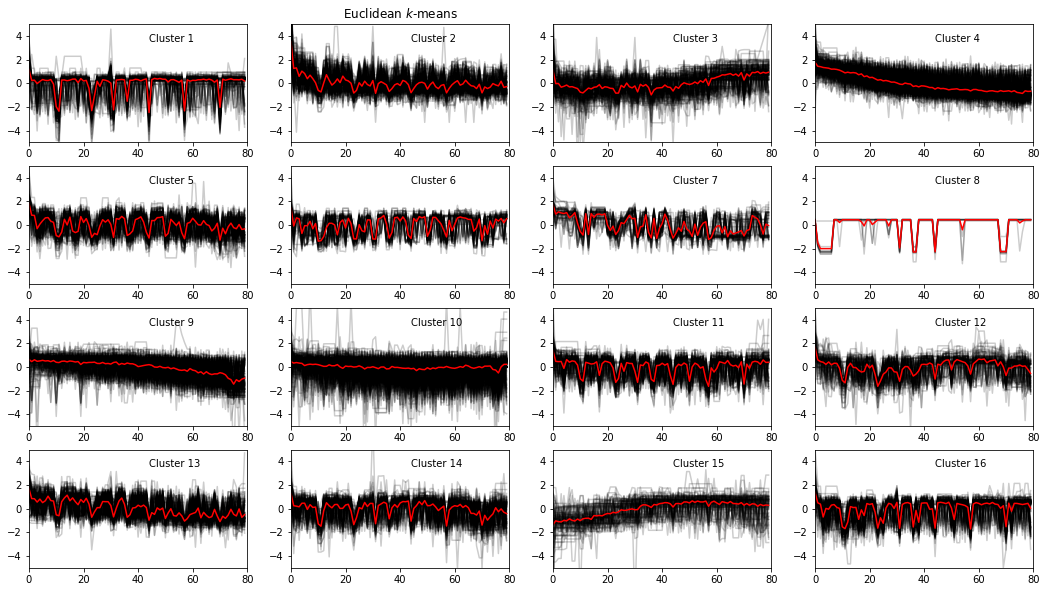

In [33]:
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=16, n_jobs=-1, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure(figsize=(18,10))
for yi in range(16):
    plt.subplot(4, 4, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [34]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=16,
                          n_init=2,
                          n_jobs=-1,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

DBA k-means


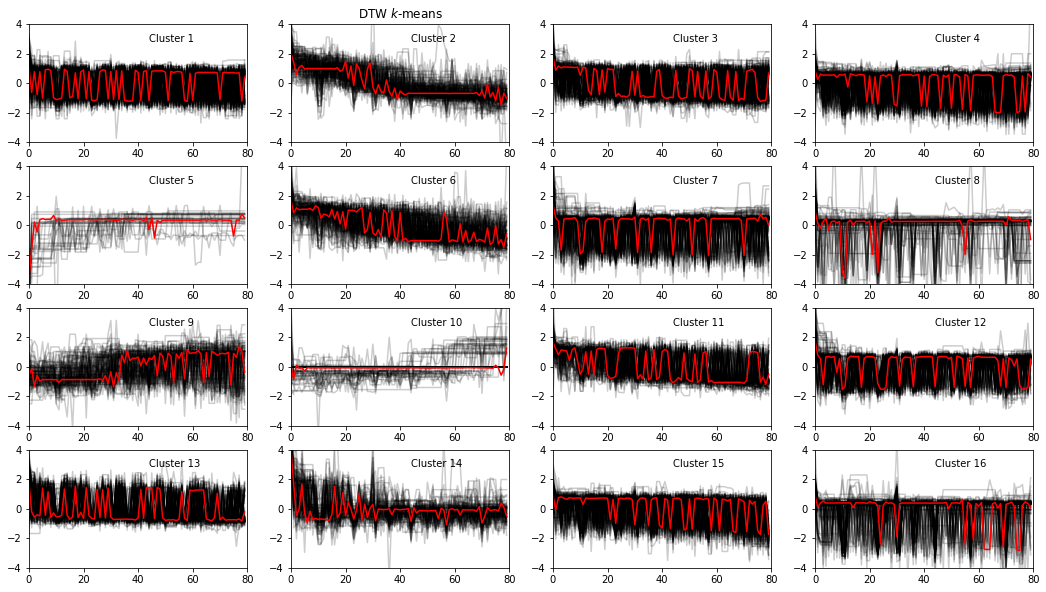

In [35]:
plt.figure(figsize=(18,10))
for yi in range(16):
    plt.subplot(4, 4, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

In [36]:

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=16,
                           n_jobs=-1,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)



Soft-DTW k-means
604.786 --> 323.014 --> 299.810 --> 295.201 --> 293.848 --> 291.620 --> 288.954 --> 288.008 --> 287.223 --> 286.674 --> 286.034 --> 285.944 --> 285.731 --> 285.286 --> 284.827 --> 284.641 --> 284.648 --> 284.486 --> 284.423 --> 284.335 --> 284.341 --> 284.235 --> 284.227 --> 284.187 --> 284.147 --> 284.016 --> 283.958 --> 283.794 --> 283.685 --> 283.499 --> 283.390 --> 283.099 --> 282.864 --> 282.779 --> 282.747 --> 282.668 --> 282.576 --> 282.528 --> 282.522 --> 282.502 --> 282.485 --> 282.459 --> 282.432 --> 282.424 --> 282.417 --> 282.409 --> 282.389 --> 282.372 --> 282.350 --> 282.335 --> 


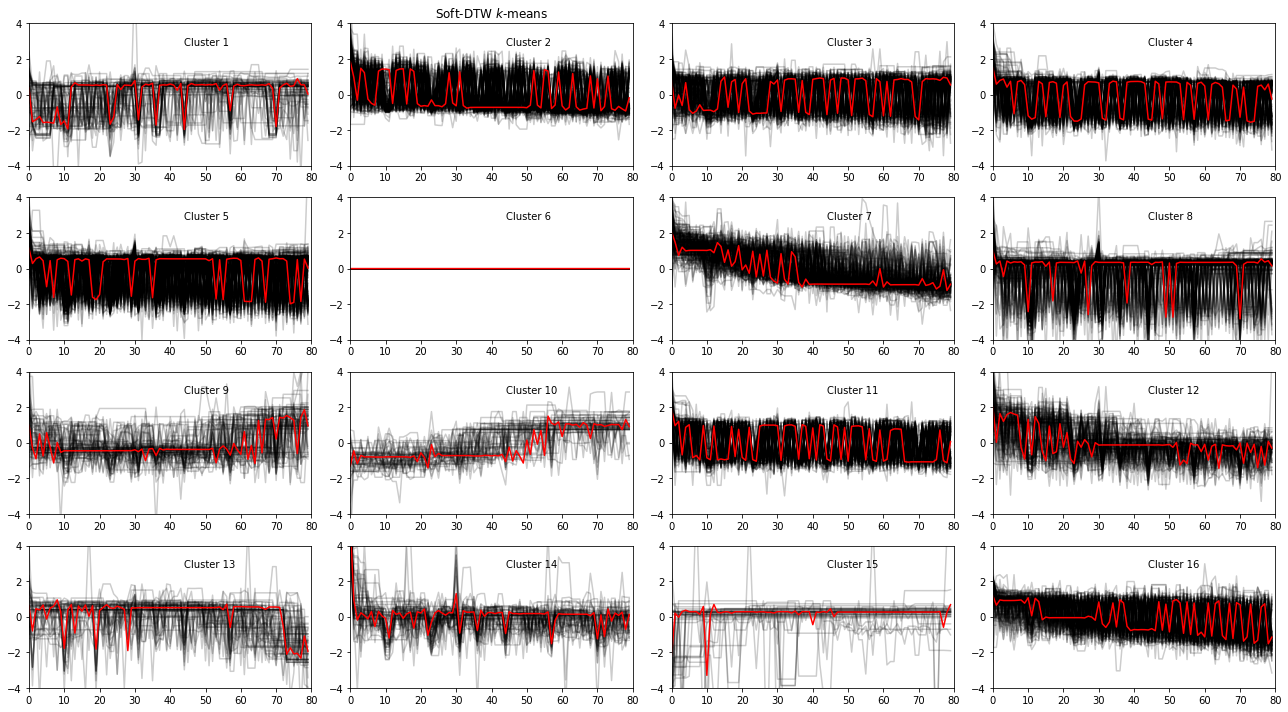

In [37]:
plt.figure(figsize=(18, 10))
for yi in range(16):
    plt.subplot(4, 4, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

In [38]:
X_train = []
class MarkovModel:


def trainMarkov(data, previousStateNum=3):
    """
    "Trains" a Markov Chain model by looking at frequencies of in/out.
    This should serve as a baseline model that our fancier models should outperform not matter what.

    :param data:
    :param previousStateNum:
    :return:
    """


IndentationError: expected an indented block (3281760761.py, line 5)